## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from itertools import chain
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.metrics import BinaryAccuracy, AUC, Recall, Precision

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
86607,00021370_000.png,No Finding,0,21370,30,F,PA,2500,3056,0.139,0.139,NaN,/data/images_010/images/00021370_000.png
89110,00022123_000.png,Effusion,0,22123,40,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00022123_000.png
105915,00028512_001.png,No Finding,1,28512,44,F,AP,3056,2544,0.139,0.139,NaN,/data/images_012/images/00028512_001.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

#  Normalize column name
def normalize_columns_name(df):
    """Remove "Unnamed:11" column and rename columns    
    """
    
    column_names = [
        "ImageIndex", "Labels", "FollowUp",
        "PatientID", "PatientAge", "PatientGender",
        "ViewPosition", "OriginalImageWidth", "OriginalImageHeight",
        "OriginalImagePixelSpacing_x", "OriginalImagePixelSpacing_y", "Path"]
    
    if df.shape[1] == 13:    
        # remove "Unnamed:11"  column (it looks meaningless)
        df = df.iloc[:, [i for i in range(0, 13) if i != 11]]
        df.columns = column_names

    return df

# Expand labels
def get_all_labels(df):
    """Extract all label names from Labels colum"""
    all_labels = np.unique(list(chain(*df['Labels'].map(lambda x: x.split('|')).tolist())))
    return [x for x in all_labels if len(x)>0]
    
def expand_label(df, all_labels):
    """ Expand Labels column into new columns for each label
    """
    
    if "Pneumonia" in df.columns :
        print("This dataframe already has Pneumonia column")
        return df
    
    for c_label in all_labels:
        if len(c_label)>1: # leave out empty labels
            df[c_label] = df['Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
    return df

def filter_by_age(df, age_min, age_max):
    """Filtering out large and small age data
    """
    age_filter = f"PatientAge > {age_min} and  PatientAge <= {age_max}"
    return df.query(age_filter)


def set_age_range(df):
    """Set age range column 
        This column is used to compare the distributions between train and validation data.
    """
    df.loc[:, "AgeRange"] = pd.cut(df["PatientAge"], bins = [10, 20, 30, 40, 50, 60, 70, 80])
    return df

TargetCol = "Pneumonia"

def make_is_pneumonia_column(df):
    df["IsPneumonia"] = df[TargetCol].map(lambda x: "Pneumonia" if x == 1 else "NotPneumonia")
    return df

In [4]:
all_df = normalize_columns_name(all_xray_df)

all_labels = get_all_labels(all_df)

all_df = expand_label(all_df, all_labels)

all_df = filter_by_age(all_df, 10, 80)

all_df = set_age_range(all_df)

all_df = make_is_pneumonia_column(all_df)

In [5]:
all_df.head()

,ImageIndex,Labels,FollowUp,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,AgeRange,IsPneumonia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(50, 60]",NotPneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(50, 60]",NotPneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(50, 60]",NotPneumonia
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(70, 80]",NotPneumonia
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(70, 80]",NotPneumonia


## Create your training and testing data:

In [6]:
def downsize_negative(df, n):
    idx = df.index
    df_neg = df[df[TargetCol] != 1]
    df_pos = df[df[TargetCol] == 1]
    
    idx_pos = df_pos.index
    idx_neg = df_neg.sample(n, random_state = 13).index
    
    idx = np.concatenate([idx_neg, idx_pos])
    
    return df.loc[idx, :]


def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    y = df[TargetCol].values
    train_data, val_data = train_test_split(df, test_size=0.2, stratify=y, random_state=13)
    
    # training data has 1:1 positive and negative ratio
    train_data = downsize_negative(train_data, (train_data[TargetCol] == 1).sum())

    # validation data has 1:5 positive and negative ratio
    val_data =  downsize_negative(val_data,  5*(val_data[TargetCol] == 1).sum())
    
    return train_data, val_data

In [7]:
train_df, val_df = create_splits(all_df)

## Check train and validation data distribution

In [8]:
def plot_label_hist(train_df, val_df, labels, title):
    n = train_df.shape[0]
    train_ratio = train_df[labels].sum() / n

    n = val_df.shape[0]
    val_ratio = val_df[labels].sum() / n

    df = pd.DataFrame({"train": train_ratio, "valid": val_ratio})
    
    ax = df.plot.barh(figsize=(10, 8), fontsize=16, grid=True)
    ax.set_title(title, fontsize=16)

def plot_compare_hist(train_df, val_df, col, title):
    n = train_df.shape[0]
    train_ratio = train_df[col].value_counts() / n

    n = val_df.shape[0]
    val_ratio = val_df[col].value_counts() / n

    df = pd.DataFrame({"train": train_ratio, "valid": val_ratio})
    
    ax = df.plot.barh(figsize=(10, 8), fontsize=16, grid=True)
    ax.set_title(title, fontsize=16)


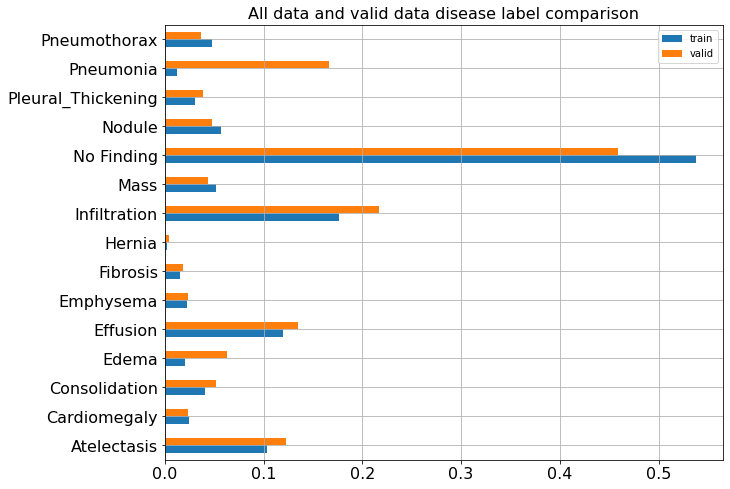

In [9]:
plot_label_hist(all_df, val_df, all_labels, "All data and valid data disease label comparison")

**Note. Except for "Pneumonia", the validation dataset has the same label distribution comparing to the origial label distribution. The ratio of "Pneumonia " is modified on purpose.**

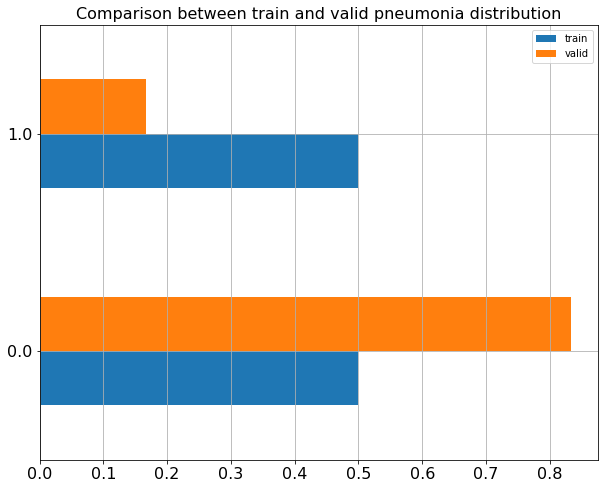

In [10]:
plot_compare_hist(train_df, val_df, "Pneumonia", "Comparison between train and valid pneumonia distribution")

**Note. In the validation dataset, the "Pneumonia" case account for 17% of the cases. The training dataset has different positive and negative distribution from validation dataset because this is modified to make positive and negative ratio be same.**

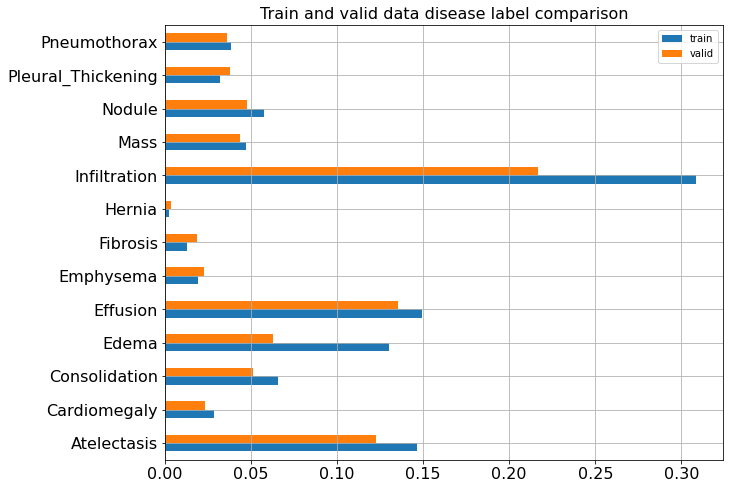

In [11]:
plot_label_hist(train_df, val_df, [l for l in all_labels if l not in ["No Finding", "Pneumonia"] ], "Train and valid data disease label comparison")

**Note. The distribution of some other labels like "Infiltration", "Edema" is somewhat modified because these labels have some association with "Pneumonia". This can be confirmed at the "5. Comorbid distribution" section in the EDA file.**

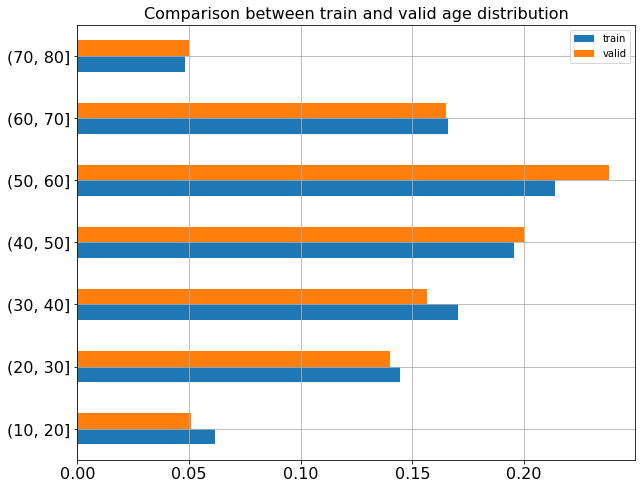

In [12]:
plot_compare_hist(train_df, val_df, "AgeRange", "Comparison between train and valid age distribution")

**Note. The age range distribution between train and validation dataset are somewhat differe but here I assume that this doesn't have significant impact on models.**

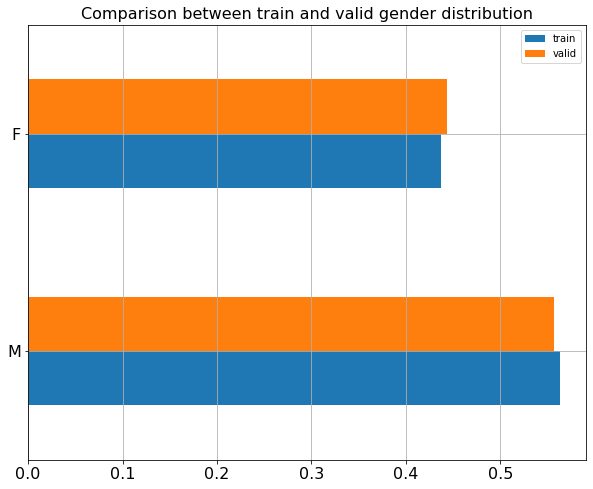

In [13]:
plot_compare_hist(train_df, val_df, "PatientGender", "Comparison between train and valid gender distribution")

**Note. There is no significant difference between train and validation dataset in  the gender distribution.**


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [14]:
IMG_SIZE = (224, 224)


def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    train_idg = ImageDataGenerator(
        rescale=1. / 255.0,
        samplewise_center = True,
        horizontal_flip = vargs["horizontal_flip"],  #True or False
        vertical_flip = False, 
        height_shift_range= vargs["height_shift_range"], # 0-1
        width_shift_range=vargs["width_shift_range"],  # 0-1
        rotation_range=vargs["rotation_range"], # degree
        shear_range = vargs["shear_range"], # degree
        zoom_range=vargs["zoom_range"], # 0-1
    ) 
    
    val_idg = ImageDataGenerator(
        rescale=1. / 255.0,
        samplewise_center = True
    )
    return [train_idg, val_idg]


def make_train_gen(vargs):

    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo

    train_gen = vargs["train_idg"].flow_from_dataframe(dataframe=vargs["train_df"], 
                                                       directory=None, 
                                                       x_col = 'Path',
                                                       y_col = 'IsPneumonia',
                                                       class_mode = 'binary',
                                                       target_size = IMG_SIZE, 
                                                       batch_size = vargs["batch_size"],    
                                                       seed = 13
                                             )
    
    return train_gen


def make_val_gen(vargs):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    val_gen = vargs["val_idg"].flow_from_dataframe(dataframe=vargs["val_df"], 
                                                   directory=None, 
                                                   x_col = 'Path',
                                                   y_col = 'IsPneumonia',
                                                   class_mode = 'binary',
                                                   target_size = IMG_SIZE, 
                                                   batch_size = vargs["val_batch_size"],
                                                   seed = 13
                                                  ) ## We've only been provided with 6 validation images
    return val_gen

In [15]:
train_df.shape, val_df.shape

((2206, 29), (1656, 29))

In [16]:
train_idg, val_idg = my_image_augmentation({    
    "horizontal_flip":True, 
    "height_shift_range":0.1, 
    "width_shift_range":0.1, 
    "rotation_range":15, 
    "shear_range":3, 
    "zoom_range":0.1
})

params = {
    "train_df":train_df, "val_df":val_df,
    "train_idg":train_idg, "val_idg":val_idg,
    "batch_size":32,
    "val_batch_size": 4000
}

train_gen = make_train_gen(params)
val_gen = make_val_gen(params)

Found 2206 validated image filenames belonging to 2 classes.
Found 1656 validated image filenames belonging to 2 classes.


In [17]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0


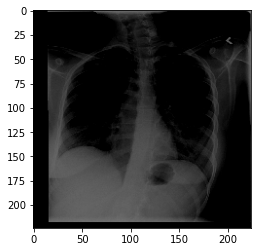

In [18]:
print(valY[0])
plt.imshow(valX[0])

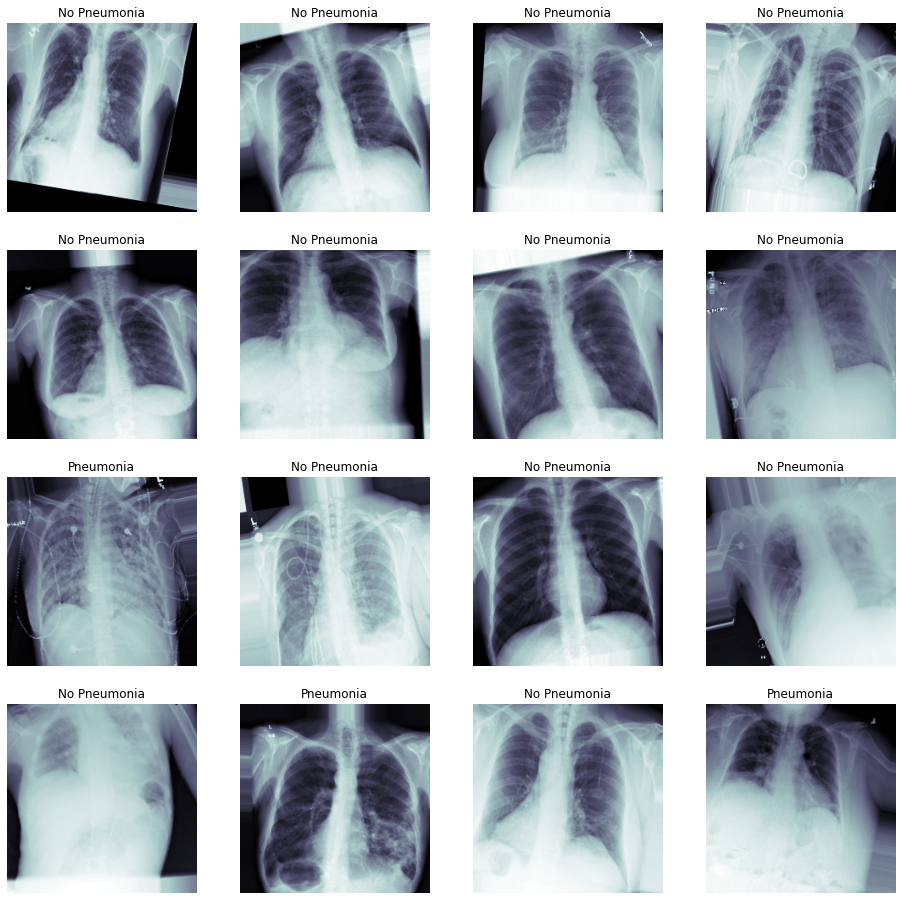

In [19]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [20]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    lay_of_interest = 'block5_pool'
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        
    return vgg_model


In [21]:
def build_my_model(pretrained_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor

    new_model = Sequential()

    # Add the convolutional part of the pretrained model
    new_model.add(pretrained_model)

    new_model.add(Flatten())

    new_model.add(Dropout(0.5))

    new_model.add(Dense(1024, activation='relu'))

    new_model.add(Dropout(0.5))

    new_model.add(Dense(512, activation='relu'))

    new_model.add(Dropout(0.5))

    new_model.add(Dense(256, activation='relu'))

    new_model.add(Dropout(0.5))

    new_model.add(Dense(128, activation='relu'))
    
    new_model.add(Dense(1, activation='sigmoid'))
    
    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [22]:
pretained_moded = load_pretrained_model()
my_model = build_my_model(pretained_moded)

optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = [BinaryAccuracy(name="acc"), AUC(name="auc"), Recall(name="recall"), Precision(name="precision")]
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

my_model.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_____________________________________________________

In [23]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= "auc", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "max", 
                             save_weights_only = True)

early = EarlyStopping(monitor= "auc", 
                      mode= "max", 
                      patience=3)

callbacks_list = [checkpoint, early]

### Start training! 

In [24]:
## train your model

# Todo
history = my_model.fit_generator(train_gen, 
                                 validation_data = (valX, valY), 
                                 epochs = 20, 
                                 callbacks = callbacks_list
                                )

Epoch 1/20
69/69 [==============================] - 78s 1s/step - loss: 0.8086 - acc: 0.4909 - auc: 0.4948 - recall: 0.4597 - precision: 0.4903 - val_loss: 0.8388 - val_acc: 0.1667 - val_auc: 0.5730 - val_recall: 1.0000 - val_precision: 0.1667

Epoch 00001: auc improved from -inf to 0.49481, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
69/69 [==============================] - 62s 896ms/step - loss: 0.7196 - acc: 0.5340 - auc: 0.5337 - recall: 0.5286 - precision: 0.5344 - val_loss: 0.7116 - val_acc: 0.3001 - val_auc: 0.5963 - val_recall: 0.8696 - val_precision: 0.1761

Epoch 00002: auc improved from 0.49481 to 0.53369, saving model to xray_class_my_model.best.hdf5
Epoch 3/20
69/69 [==============================] - 61s 890ms/step - loss: 0.7131 - acc: 0.5163 - auc: 0.5146 - recall: 0.5177 - precision: 0.5163 - val_loss: 0.7434 - val_acc: 0.1667 - val_auc: 0.6091 - val_recall: 1.0000 - val_precision: 0.1667

Epoch 00003: auc did not improve from 0.53369
Epoch 4/20
69/69 [====

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [25]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

my_model.load_weights(weight_path)

pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

1656/1656 [==============================] - 14s 9ms/step


In [26]:
plt.style.use("ggplot")
    
def plot_auc(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

    
# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    N = len(history.history["loss"])
    fig, ax = plt.subplots(1,1, figsize = (9, 9))
    ax.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    ax.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    ax.plot(np.arange(0, N), history.history["val_auc"], label="val_auc")
    ax.plot(np.arange(0, N), history.history["val_recall"], label="val_recall")
    ax.set_title("Training Loss and Accuracy on Dataset")
    ax.set_xlabel("Epoch #")
    ax.set_ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

In [27]:
history.history


{'val_loss': [0.8387780094492263,
  0.7116215424837121,
  0.7434018945348435,
  0.6610267792922863,
  0.6672008397498569,
  0.6977132714313009,
  0.6984844775735468,
  0.6437644566890698,
  0.5748084331480201,
  0.6377142425896465,
  0.6270712709081345,
  0.620358607619281,
  0.6044666194109525,
  0.7076878731953349,
  0.5798494709286712,
  0.5791748356128085,
  0.6314215196503533,
  0.7004571384277897,
  0.6117440787490439,
  0.6434301022746137],
 'val_acc': [0.1666666716337204,
  0.3001207709312439,
  0.1666666716337204,
  0.66847825050354,
  0.5978260636329651,
  0.5428743958473206,
  0.52173912525177,
  0.6189613342285156,
  0.6986715197563171,
  0.6080917716026306,
  0.6539855003356934,
  0.634661853313446,
  0.6527777910232544,
  0.5102657079696655,
  0.6878019571304321,
  0.6884058117866516,
  0.6413043737411499,
  0.5416666865348816,
  0.6757246255874634,
  0.6117149591445923],
 'val_auc': [0.5729547142982483,
  0.596299409866333,
  0.6091013550758362,
  0.6243856549263,
  0.62

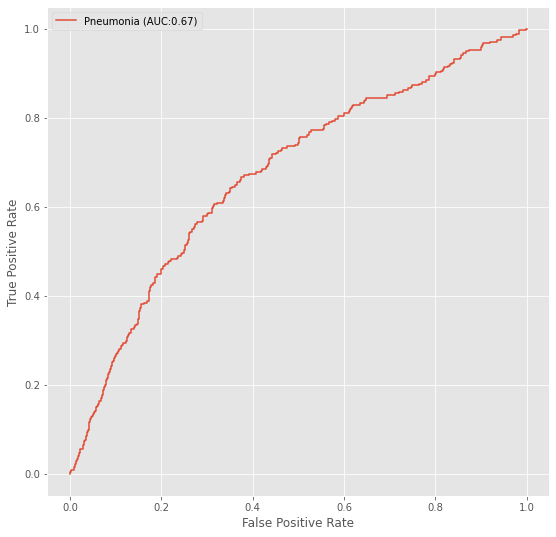

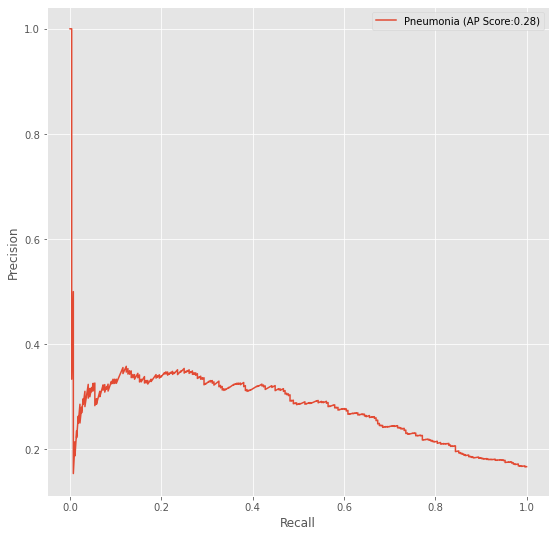

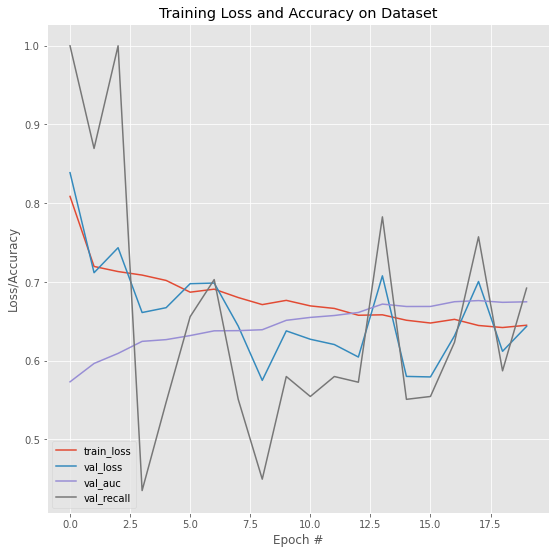

In [28]:
## plot figures
true_Y = valY

plot_auc(true_Y, pred_Y)

plot_precision_recall_curve(true_Y, pred_Y)

plot_history(history)


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [29]:

precision, recall, thresholds = precision_recall_curve(true_Y, pred_Y)
f1_scores = []
for idx in range(len(thresholds)):    
    f1_score = calc_f1(precision[idx],recall[idx])
    f1_scores.append(f1_score)
    print(f"F1 Score: {f1_score}  , Threshold: {thresholds[idx]}, {idx}")


F1 Score: 0.28615863141524106  , Threshold: 0.04118674248456955, 0
F1 Score: 0.28526970954356845  , Threshold: 0.04286184161901474, 1
F1 Score: 0.28541774779449924  , Threshold: 0.07020718604326248, 2
F1 Score: 0.2855659397715472  , Threshold: 0.07036692649126053, 3
F1 Score: 0.28571428571428564  , Threshold: 0.07123154401779175, 4
F1 Score: 0.28586278586278585  , Threshold: 0.07174193859100342, 5
F1 Score: 0.2860114404576183  , Threshold: 0.07294604927301407, 6
F1 Score: 0.2861602497398543  , Threshold: 0.07897349447011948, 7
F1 Score: 0.2863092139510672  , Threshold: 0.07914998382329941, 8
F1 Score: 0.28645833333333326  , Threshold: 0.08220551162958145, 9
F1 Score: 0.28660760812923397  , Threshold: 0.08255432546138763, 10
F1 Score: 0.2867570385818561  , Threshold: 0.08494287729263306, 11
F1 Score: 0.28690662493479396  , Threshold: 0.08557277917861938, 12
F1 Score: 0.28705636743215035  , Threshold: 0.0856771469116211, 13
F1 Score: 0.28720626631853785  , Threshold: 0.086866095662117, 1

Text(0, 0.5, 'F1 score')

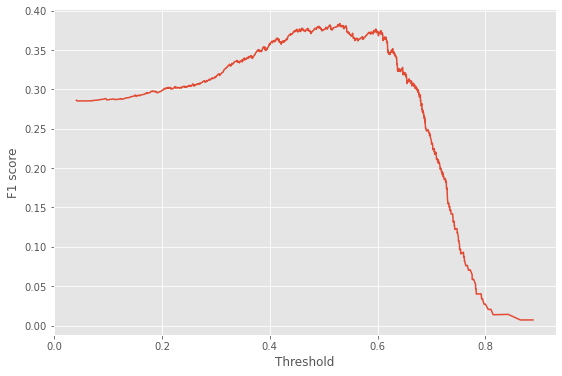

In [30]:
plt.figure(figsize=(9, 6))

plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 score')

In [35]:
i_optimal = np.argmax(f1_scores)

f1_scores[i_optimal], thresholds[i_optimal] 

(0.3836633663366337, 0.52995515)

In [36]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

THRESHOLD = thresholds[i_optimal] 

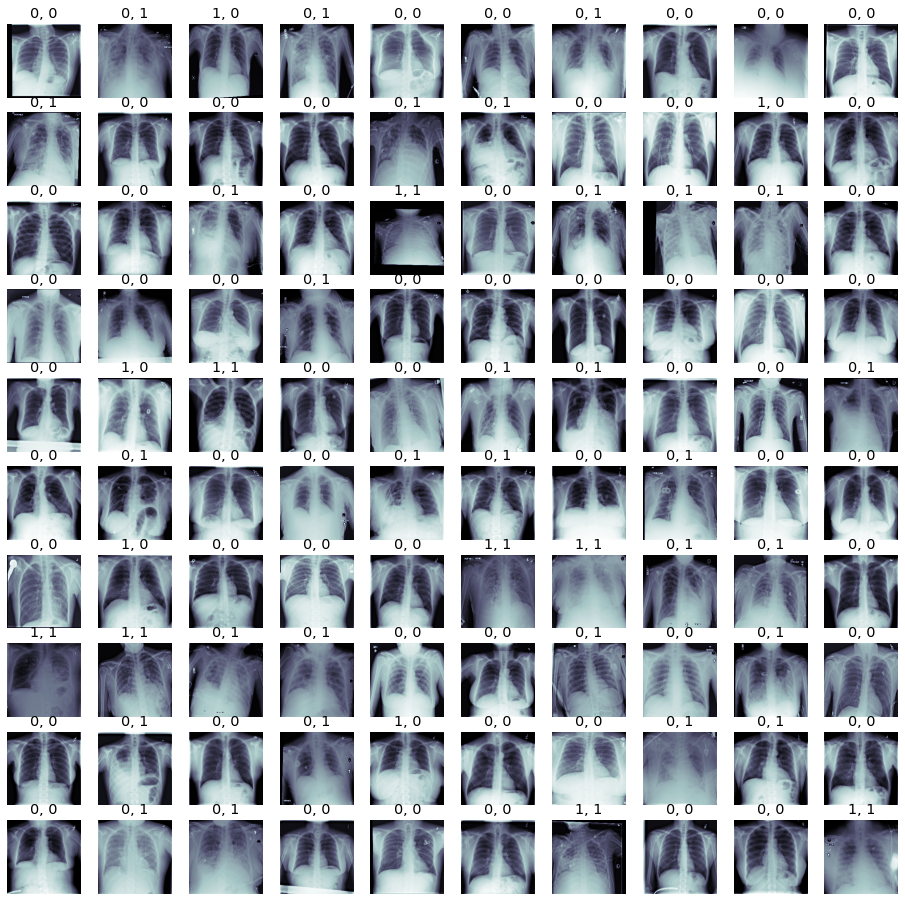

In [37]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [38]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)